# Feature Catalouge
Here we'll do a generic review of some of the exploratory initial logistic analysis done on the first set of Aqualab Validation study, and identify some features that could be useful to look at from Stefan's struggle detection study.

### Basic imports/installs/data manipulation

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install rfpimp
!pip install mord
!pip install pypair
!pip install phik
!pip install MASS

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10649 sha256=41713f5bd9034af81a277c992ec513e38c29a762807744caca0de5d784f42429
  Stored in directory: /root/.cache/pip/wheels/6a/12/08/d5bc35127c8d69d39c1f3736a95419ab4763cc0c80ed65bf41
Successfully built rfpimp
  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=c5053db1eec5fcb1dc4b6399d6b0fefa4f8065178372b567c87a557a6ac562af
  Stored in directory: /root/.cache/pip/wheels/77/00/19/3cea86fbfc737ec4acb515cd94497dcc33f943fa157548b96c
Successfully built mord
  Preparing metadata (setup.py) ... done
  Created wheel for pypair: filename=pypair-3.0.9-py3-none-any.whl size=24525 sha256=b9bd0550f3fd3ca4ceb970111de690ed3f65be7213ad54137ef2be55b3e533e2
  Stored in directory: /root/.cache/pip/wheels/27/d8/78/bc27988fe8ef1086879ea558f8c9bc03d8c51e4ff2c1ee8344
Successfully built pypair
     ━━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pointbiserialr

from phik.report import plot_correlation_matrix
from sklearn.metrics import confusion_matrix

from scipy.stats import kendalltau

import scipy.stats as stats

import sklearn
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Perceptron
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer,recall_score, roc_curve, roc_auc_score
from tensorflow import keras
from sklearn import linear_model
from scipy.stats import chi2


import statsmodels.api as sm

import rfpimp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from pypair.association import binary_continuous


import json
import urllib.request as ur
from collections import Counter
from io import BytesIO
from math import ceil, pi
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
from mord import LogisticAT

import statsmodels.api as sm





In [3]:
## Load in feature values and columns from tsv

ply_features = pd.read_csv("/content/drive/MyDrive/AqualabValidation_Zach/featuredata/AQUALAB_20220601_to_20220715_c2ad3af_player-features.tsv", sep = "	").dropna()
#remove NA values
ply_features = ply_features.loc[ply_features.PlayerID.isna() != True]

id_col = ['PlayerID']
job_col = []
aggr_col = []
for col in ply_features.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  if prefix.startswith('job'):
    job_col.append(pieces[1])
  else:
    aggr_col.append(col)
job_col = Counter(job_col)
print(f"{len(ply_features.columns)} perjobfeatures in {len(job_col)} groups:")
pprint(job_col, compact=False)

job_col = [key for key in job_col.keys() if key.startswith('Job')]
aggr_col = aggr_col[1:]
pprint(aggr_col)


1272 perjobfeatures in 22 groups:
Counter({'JobActiveTime': 57,
         'JobArgumentationTime': 57,
         'JobCompletionTime': 57,
         'JobDiveSitesCount': 57,
         'JobDiveTime': 57,
         'JobExperimentationTime': 57,
         'JobGuideCount': 57,
         'JobHelpCount': 57,
         'JobHelpCount-ByTask': 57,
         'JobLocationChanges': 57,
         'JobLocationChanges-ByTask': 57,
         'JobModelingTime': 57,
         'JobTasksCompleted': 57,
         'SyncCompletionTime': 57,
         'JobsAttempted': 57,
         'JobsAttempted-job-name': 57,
         'JobsAttempted-num-starts': 57,
         'JobsAttempted-num-completes': 57,
         'JobsAttempted-percent-complete': 57,
         'JobsAttempted-avg-time-per-attempt': 57,
         'JobsAttempted-std-dev-per-attempt': 57,
         'JobsAttempted-job-difficulties': 57})
['ActiveTime',
 'JobsCompleted',
 'SessionDiveSitesCount',
 'SessionDuration',
 'SessionGuideCount',
 'SessionHelpCount',
 'SessionID',
 'Ses

In [4]:
# import job complexity scores
DBexport = json.load(open("/content/drive/MyDrive/AqualabValidation_Zach/DBExport.json"))
Complexity_df = pd.DataFrame(columns=['job_id', 'job_name', 'argumentation', 'experimentation', 'modeling'])
for id, job in enumerate(DBexport.get('jobs')):
  Complexity_df.loc[len(Complexity_df.index)] = [id, job['id'], job['difficulties']['argumentation'],
                                                 job['difficulties']['experimentation'],
                                                 job['difficulties']['modeling']]

# import player complexity scores
labels = pd.read_excel("/content/drive/MyDrive/AqualabValidation_Zach/surveydata/Aqualab Practices Survey June 2022 scores final.xlsx",
                       sheet_name='Simplified')
labels = labels.rename({'Modeling_score_max_5)':'Modeling_score_max_5'}, axis='columns')

player_complexity = pd.merge(ply_features, labels, left_on="PlayerID", right_on="user_code", how="inner")


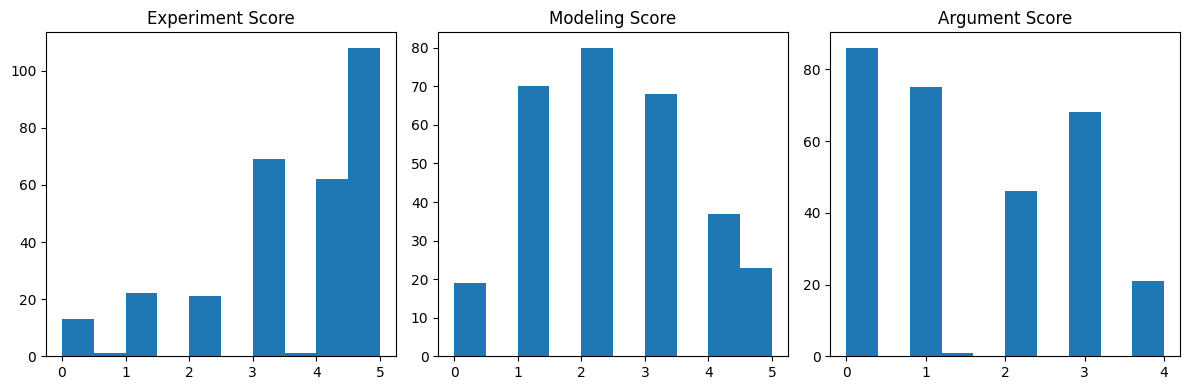

,Experiment_score_max_5,Modeling_score_max_5,Argument_score_max_4
count,297.000000,297.000000,297.000000
mean,3.580161,2.349586,1.538478
std,1.453780,1.339584,1.308179
min,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,3.000000
max,5.000000,5.000000,4.000000


In [5]:
experiment_score = labels['Experiment_score_max_5']
modeling_score = labels['Modeling_score_max_5']
argument_score = labels['Argument_score_max_4']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(experiment_score)
axes[0].set_title('Experiment Score')
axes[1].hist(modeling_score)
axes[1].set_title('Modeling Score')
axes[2].hist(argument_score)
axes[2].set_title('Argument Score')

plt.tight_layout()

plt.show()


labels.describe()

# Correction: Adjusting buckets for inconsitent values
We have some inconsistent values(3.5s) for some of our histograms- lets do a dive into our data.

We can see that we have some inconsistent values not aligned with our ordinal 1-5/1-6 scores. Let's round those to the nearest whole number. We can also create a new binary column for above/below the mean. Let's also make binary columns for above the top quartile, and everyone else.

In [108]:
# print(experiment_score.value_counts())
# print(modeling_score.value_counts())
# print(argument_score.value_counts())

argument_score_mean_binary = (argument_score > argument_score.mean()).astype(int)
modeling_score_mean_binary = (modeling_score > modeling_score.mean()).astype(int)
experiment_score_mean_binary = (experiment_score > experiment_score.mean()).astype(int)

# print(argument_score_mean_binary.value_counts())
# print(modeling_score_mean_binary.value_counts())
# print(experiment_score_mean_binary.value_counts())

argument_score_4= (argument_score >=4).astype(int)
modeling_score_4 = (modeling_score >= 4).astype(int)
experiment_score_4 = (experiment_score >= 4).astype(int)

four_scores = pd.concat([argument_score_4, modeling_score_4, experiment_score_4], axis=1)


print(argument_score_4.value_counts())
print(modeling_score_4.value_counts())
print(experiment_score_4.value_counts())

0    276
1     21
Name: Argument_score_max_4, dtype: int64
0    237
1     60
Name: Modeling_score_max_5, dtype: int64
1    170
0    127
Name: Experiment_score_max_5, dtype: int64


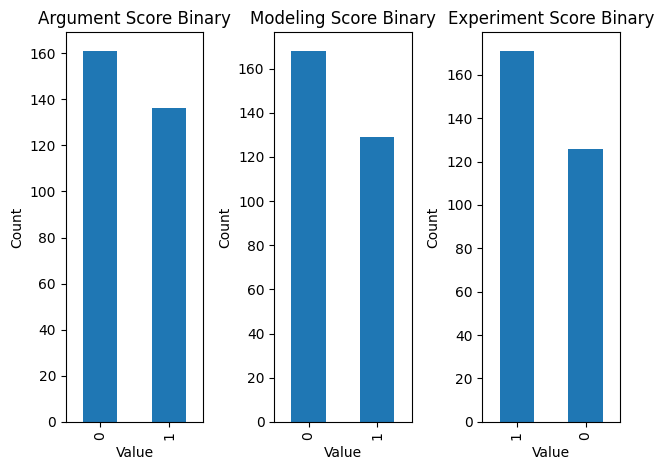

In [29]:
# Plotting argument_score_mean_binary
plt.subplot(1, 3, 1)
argument_score_mean_binary.value_counts().plot(kind='bar')
plt.title('Argument Score Binary')
plt.xlabel('Value')
plt.ylabel('Count')

# Plotting modeling_score_mean_binary
plt.subplot(1, 3, 2)
modeling_score_mean_binary.value_counts().plot(kind='bar')
plt.title('Modeling Score Binary')
plt.xlabel('Value')
plt.ylabel('Count')

# Plotting experiment_score_mean_binary
plt.subplot(1, 3, 3)
experiment_score_mean_binary.value_counts().plot(kind='bar')
plt.title('Experiment Score Binary')
plt.xlabel('Value')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [36]:
binary_scores = pd.concat([argument_score_mean_binary, modeling_score_mean_binary, experiment_score_mean_binary], axis=1)

binary_scores


,Argument_score_max_4,Modeling_score_max_5,Experiment_score_max_5
0,0,0,0
1,1,1,1
2,1,1,0
3,1,0,1
4,1,1,1
...,...,...,...
292,0,0,1
293,0,1,0
294,0,0,0
295,1,1,1


# Correlation Coefficients

Much of the existing feature data provides a very general look at per-level task completion and actions. Because we lack more granularity in the existing features, for now we'll be focusing on measuring simple binary per-level variables against an ordinal response (EMA scores). This top-down approach can help to identify levels that may have more explanatory power in further analysis.

In [ ]:
df = player_complexity

correlation_columns = ['Experiment_score_max_5', 'Modeling_score_max_5', 'Argument_score_max_4']

for job in df:
  if "Job" in job:
    df[job] = df[job].map(lambda x: 1 if x != 0 else x)
    for corr in correlation_columns:
      pbs = stats.pointbiserialr(binary_scores[corr], df[job])
      if pbs.pvalue < 0.01 and pbs.statistic > 0.2: #benjamini hochberg to adjust alpha
        print(f'{job}: {pbs.statistic}, {pbs.pvalue}')

##0.2-0.25 corr coeff is reasonable

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


ValueError: ignored

For measuring our new binary outcome columns against our binary features, we don't want to use Pearson's r, as it can be misleading with binary data. Instead, let's try phi's correlation(Matthew's coeff)

In [113]:
# df = player_complexity

correlation_columns = ['Experiment_score_max_5', 'Modeling_score_max_5', 'Argument_score_max_4']

for job in df:
  if "Job" in job:
    df[job] = df[job].map(lambda x: 1 if x != 0 else x)
    for corr in correlation_columns:
      pbs = sklearn.metrics.cohen_kappa_score(df[job], four_scores[corr])
      print(pbs)
      # if pbs.pvalue < 0.01 and pbs.statistic > 0.2: #benjamini hochberg to adjust alpha
      #   print(f'{job}: {pbs.statistic}, {pbs.pvalue}')



0.0
0.0
0.0
-0.06006526616357322
0.0099074679876624
0.0038605281531070013
-0.02189552705661546
0.009035344140313595
0.00046067027525054094
0.0
0.0
0.0
0.0
0.0
0.0
-0.0009213237968239696
0.01664429530201328
-0.0019652156824212508
0.02549394518801773
-0.03686150605581884
-0.01488095238095255
-0.06499627883899772
-0.05355776587605199
-0.015455950540958385
-0.056328635575512376
-0.07130151200711521
-0.016050621189906744
0.007564858216921211
-0.04612133267031315
0.009940715012874968
-0.056328635575512376
-0.07130151200711521
-0.016050621189906744
-0.056328635575512376
-0.07130151200711521
-0.016050621189906744
-0.056328635575512376
-0.07130151200711521
-0.016050621189906744
-0.056328635575512376
-0.07130151200711521
-0.016050621189906744
-0.056328635575512376
-0.07130151200711521
-0.016050621189906744
-0.07215408417229074
-0.06603437210297369
0.004517633343048555
-0.05883539989685871
-0.05191471154531846
-0.009909647333139038
-0.07985456504174526
-0.05453770771197264
-0.010862480990658119
-

# Jobs to focus on
We'll specifically be focusing on jobs **12, 13, 15, 20, 32, 36** for the purposes of our logistic regression






## Job 12 Logistic Regression

Argumentation


*   coeff: 1.7807
*   p-value: 0.0000
(Also has lowest AIC/BIC Values)






In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4'],
                        df[['job12_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

## turn agument_score_max_4 into 1 hot encoding object and pass as dependent
# check orderedmodels docs for handling ordinal dependent variable

Optimization terminated successfully.
         Current function value: 1.449796
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                              
================================================================================
Dep. Variable:     Argument_score_max_4   Log-Likelihood:                -245.02
Model:                     OrderedModel   AIC:                             500.0
Method:              Maximum Likelihood   BIC:                             515.7
Date:                  Thu, 13 Jul 2023                                         
Time:                          04:18:57                                         
No. Observations:                   169                                         
Df Residuals:                       164                                         
Df Model:                             5                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job12_JobTasksCompleted     1.7807      0.508      3.505      0.000       0.785       2.776
0.0/1.0                    -0.8234      0.174     -4.734      0.000      -1.164      -0.482
1.0/2.0                     0.2800      0.125      2.243      0.025       0.035       0.525
2.0/3.0                    -0.4804      0.202     -2.378      0.017      -0.876      -0.084
3.0/4.0                     0.6753      0.163      4.145      0.000       0.356       0.995
===========================================================================================
"""

## Job 13 Logistic Regression

Argumentation


*   coeff: 2.0304
*   p-value: 0.001
(Also has lowest AIC/BIC Values)






In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4'],
                        df[['job13_JobTasksCompleted']],
                        distr='logit')

# mod_prob = OrderedModel(df['Argument_score_max_4'],
#                         df[['job13_JobTasksCompleted']],
#                         distr='logit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

# do a group by for the binary against the ordinal score and see if there's a lack of data

# coarse grain: argument_Score with above average, below average

#increasing granularity: high/low quartile

# If data is imbalanced:

#if 3/4 bin is underrepresented, combine

#convert ordinal to binary or change the scale of the ordinal

#split at 2 or split at mean

# put data in right bins

###########

## C4.5 -decision tree in scikit learn
##jrip
#XGboost

##Use sequential neural network- prove efficacy of the features we selected

Optimization terminated successfully.
         Current function value: 1.453276
         Iterations: 15
         Function evaluations: 18
         Gradient evaluations: 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                              
================================================================================
Dep. Variable:     Argument_score_max_4   Log-Likelihood:                -245.60
Model:                     OrderedModel   AIC:                             501.2
Method:              Maximum Likelihood   BIC:                             516.9
Date:                  Thu, 13 Jul 2023                                         
Time:                          05:06:07                                         
No. Observations:                   169                                         
Df Residuals:                       164                                         
Df Model:                             5                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job13_JobTasksCompleted     2.0304      0.607      3.348      0.001       0.842       3.219
0.0/1.0                    -0.8501      0.173     -4.918      0.000      -1.189      -0.511
1.0/2.0                     0.2699      0.125      2.162      0.031       0.025       0.515
2.0/3.0                    -0.4889      0.202     -2.421      0.015      -0.885      -0.093
3.0/4.0                     0.6834      0.164      4.163      0.000       0.362       1.005
===========================================================================================
"""

## Job 15 Logistic Regression


Modeling


*   coeff: 1.4519
*   p-value: 0.005
(Also has lowest AIC/BIC Values)







In [ ]:
mod_prob = OrderedModel(df['Modeling_score_max_5'],
                        df[['job15_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 1.619197
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                              
================================================================================
Dep. Variable:     Modeling_score_max_5   Log-Likelihood:                -273.64
Model:                     OrderedModel   AIC:                             559.3
Method:              Maximum Likelihood   BIC:                             578.1
Date:                  Thu, 13 Jul 2023                                         
Time:                          04:19:05                                         
No. Observations:                   169                                         
Df Residuals:                       163                                         
Df Model:                             6                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job15_JobTasksCompleted     1.4519      0.514      2.825      0.005       0.445       2.459
0.0/1.0                    -2.6965      0.327     -8.244      0.000      -3.338      -2.055
1.0/2.0                     0.7491      0.147      5.101      0.000       0.461       1.037
2.0/3.0                     0.1627      0.131      1.242      0.214      -0.094       0.419
3.0/4.0                    -0.0692      0.168     -0.412      0.681      -0.399       0.260
4.0/5.0                     0.2088      0.210      0.996      0.319      -0.202       0.620
===========================================================================================
"""

## Job 20 Logistic Regression


No statistically significant results found for this job






## Job 32 Logistic Regression


Modeling


*   coeff: 1.8073
*   p-value: 0.004
(Also has lowest AIC/BIC Values)

Argumentation

*   coeff: 1.9615
*   p-value: 0.004






In [ ]:
mod_prob = OrderedModel(df['Modeling_score_max_5'],
                        df[['job32_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 1.618596
         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                              
================================================================================
Dep. Variable:     Modeling_score_max_5   Log-Likelihood:                -273.54
Model:                     OrderedModel   AIC:                             559.1
Method:              Maximum Likelihood   BIC:                             577.9
Date:                  Thu, 13 Jul 2023                                         
Time:                          04:19:09                                         
No. Observations:                   169                                         
Df Residuals:                       163                                         
Df Model:                             6                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job32_JobTasksCompleted     1.8073      0.626      2.888      0.004       0.581       3.034
0.0/1.0                    -2.7233      0.327     -8.339      0.000      -3.363      -2.083
1.0/2.0                     0.7464      0.147      5.076      0.000       0.458       1.035
2.0/3.0                     0.1684      0.131      1.288      0.198      -0.088       0.425
3.0/4.0                    -0.0526      0.168     -0.312      0.755      -0.383       0.278
4.0/5.0                     0.2078      0.210      0.989      0.323      -0.204       0.620
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4'],
                        df[['job32_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 1.462297
         Iterations: 15
         Function evaluations: 18
         Gradient evaluations: 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                              
================================================================================
Dep. Variable:     Argument_score_max_4   Log-Likelihood:                -247.13
Model:                     OrderedModel   AIC:                             504.3
Method:              Maximum Likelihood   BIC:                             519.9
Date:                  Thu, 13 Jul 2023                                         
Time:                          04:19:15                                         
No. Observations:                   169                                         
Df Residuals:                       164                                         
Df Model:                             5                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job32_JobTasksCompleted     1.9615      0.683      2.872      0.004       0.623       3.300
0.0/1.0                    -0.8661      0.172     -5.024      0.000      -1.204      -0.528
1.0/2.0                     0.2605      0.125      2.085      0.037       0.016       0.505
2.0/3.0                    -0.5112      0.202     -2.533      0.011      -0.907      -0.116
3.0/4.0                     0.6640      0.164      4.045      0.000       0.342       0.986
===========================================================================================
"""

## Job 36 Logistic Regression


Modeling


*   coeff: 1.5020
*   p-value: 0.023

Argumentation

*   coeff: 1.7244
*   p-value: 0.010






In [ ]:
mod_prob = OrderedModel(df['Modeling_score_max_5'],
                        df[['job36_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 1.627753
         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                              
================================================================================
Dep. Variable:     Modeling_score_max_5   Log-Likelihood:                -275.09
Model:                     OrderedModel   AIC:                             562.2
Method:              Maximum Likelihood   BIC:                             581.0
Date:                  Thu, 13 Jul 2023                                         
Time:                          04:19:39                                         
No. Observations:                   169                                         
Df Residuals:                       163                                         
Df Model:                             6                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job36_JobTasksCompleted     1.5020      0.659      2.280      0.023       0.211       2.793
0.0/1.0                    -2.7315      0.327     -8.366      0.000      -3.371      -2.092
1.0/2.0                     0.7447      0.147      5.059      0.000       0.456       1.033
2.0/3.0                     0.1613      0.131      1.233      0.217      -0.095       0.418
3.0/4.0                    -0.0765      0.168     -0.455      0.649      -0.406       0.253
4.0/5.0                     0.1832      0.211      0.869      0.385      -0.230       0.596
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4'],
                        df[['job36_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 1.487184
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                              
================================================================================
Dep. Variable:     Argument_score_max_4   Log-Likelihood:                -251.33
Model:                     OrderedModel   AIC:                             512.7
Method:              Maximum Likelihood   BIC:                             528.3
Date:                  Thu, 13 Jul 2023                                         
Time:                          05:56:35                                         
No. Observations:                   169                                         
Df Residuals:                       164                                         
Df Model:                             5                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job14_JobTasksCompleted     0.0763      0.372      0.205      0.838      -0.653       0.806
0.0/1.0                    -0.9124      0.181     -5.051      0.000      -1.266      -0.558
1.0/2.0                     0.2404      0.125      1.923      0.055      -0.005       0.486
2.0/3.0                    -0.5487      0.202     -2.721      0.007      -0.944      -0.153
3.0/4.0                     0.6103      0.164      3.723      0.000       0.289       0.932
===========================================================================================
"""

# Review/Insights
Included above are logistic regressions with statistically significant results(p < alpha 0.05). It is worth noting that these regression models account for an ordinal **explanatory** variable against a binary response, meaning that our data is inverted. However, I believe that this shouldn't matter for the validity of the sigmoid curve and the model as a whole(needs to be verified).

We now have 7 job-outcome regressions with potentially statistically significant results. Models with specifically high corr. coefficients include:


*   Job36: Modeling
*   Job36: Argumentation
*   Job32: Modeling
*   Job32: Argumentation
*   Job15: Modeling
*   Job13: Argumentation (coeff > 2)
*   Job12: Argumentation

*Note that correlation coefficients are scaled logarithmically and can be greater than 1.*


One weakness in these current data is that when looking for examples where high ordinal values correlate to a binary value of true for a given job, the sheer number of jobs and size of the game yields relatively few "positive" results. This makes it difficult to construct a complete sigmoid curve, as shown below:

Optimization terminated successfully.
         Current function value: 0.190710
         Iterations 8


Text(0, 0.5, 'job13_JobTasksCompleted')

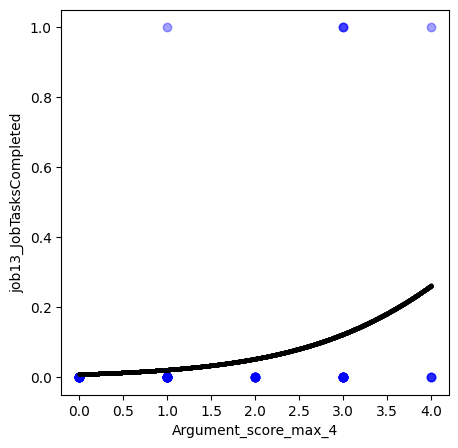

In [ ]:
log_reg = smf.logit("job13_JobTasksCompleted ~ Argument_score_max_4", data=df).fit()
compNew = pd.DataFrame({'Argument_score_max_4': np.linspace(df["Argument_score_max_4"].min(), df["Argument_score_max_4"].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df["Argument_score_max_4"], df["job13_JobTasksCompleted"], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel('Argument_score_max_4')
ax.set_ylabel('job13_JobTasksCompleted')



A greater population of "positive" datapoints will yield a curve with a greater function value. Another option could potentailly be to create tentative logistic regression models and test them against the new dataset.

## Next Steps
The classification algorithms used in the struggle detection study could help identify significant features as they are implemented and tested against the data. AUC and ROC can help to judge the efficacy of these models with different feature measures. By calculating SHAP values for different features, we could cross-validate features that we think may be good candidates for explanatory power, and detect other features as we add them in.

The struggle detection study had a similar issue to the one we currently face- a lack of positive binary values. As Stefan notes in the paper, most models perform poorly on minority class prediction. The same SMOTE technique used in the struggle detection paper could potentially help to yield a more balanced dataset and better logistic regression models. Some more specific features, such as how many times the modeling room was visited, could potentially be translated from aggregate to per-count and used to obtain a greater level of granularity.

In [ ]:

x = df[['job13_JobTasksCompleted', 'job15_JobTasksCompleted', 'job32_JobTasksCompleted', 'job36_JobTasksCompleted']]
x = sm.add_constant(x)

log_reg = sm.OLS(df['Argument_score_max_4'], x).fit()
print(log_reg.summary())

                             OLS Regression Results                             
Dep. Variable:     Argument_score_max_4   R-squared:                       0.109
Model:                              OLS   Adj. R-squared:                  0.087
Method:                   Least Squares   F-statistic:                     4.999
Date:                  Thu, 13 Jul 2023   Prob (F-statistic):           0.000792
Time:                          06:29:55   Log-Likelihood:                -270.95
No. Observations:                   169   AIC:                             551.9
Df Residuals:                       164   BIC:                             567.6
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

ValueError: ignored

A